# The Perceptron

The perceptron model as described in the README.md file will be used to classify countries as transit-oriented(1) or non-transit-oriented(0) based on its overall fossil fuel consumption.

First, we need to determine how to quantify the label of transit-oriented. Based on the metrics that we have for each country, railway passengers carried, quality of railroad infrastructure, quality of air transport infrastructure, and quality of port infrastructure are positive indicators and will be weighted at 0.25, 0.25, 0.05, and 0.1 respectively. CO₂ emission from road transport per GDP, deaths by 2/3 wheeler users, air pollution, and mortality from road traffic are negative indicators weighted at 0.05, 0.1, 0.1, and 0.1 respectively. We also should normalize each value so that they are comparable on a 0 to 1 scale. As a result, we will use $$x_{\text{norm}} = \frac{x - x_{\min}}{x_{\max} - x_{\min}}$$ for positive indicators and $$x_{\text{norm}} = \frac{x_{\max}-x}{x_{\max} - x_{\min}}$$ for negative indicators. With these metrics, we then can obtain a transit index calculated by $$\text{Transit Index} = \sum (\text{Normalized Positive Indicators} \times \text{Weight}) - \sum (\text{Normalized Negative Indicators} \times \text{Weight})$$ If the index is greater than 1, then we will refer to that country as transit-oriented. If it is less than or equal to 0, then we will refer to that country as not transit-oriented.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

### Cleaning Up Data and Calculating the Transit Index

In [3]:
#read csv file with all country transit and socioeconomic data
df = pd.read_csv("DataPerceptron.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'DataPerceptron.csv'

In [4]:
# clean up data file
# isolate rows with positive indicators: railway passengers carried, quality of railroad, air, port infrastructure
# isolate rows with negative indicators: CO₂ emission from road transport per GDP, deaths by 2/3 wheeler users, air pollution, mortality from road traffic

row_ind = [19, 16, 14, 12, 2, 4, 9, 10, 26]
col_filled = ~df.loc[row_ind].isin([".."]).any() # only keep countries with nonempty rows

fil_df = df.loc[row_ind, col_filled] # create new data table with isolated rows
fil_df.head()

,Unnamed: 0,Time,Time Code,Indicator Name,Indicator Code,Albania [ALB],Armenia [ARM],Austria [AUT],Belgium [BEL],Bosnia and Herzegovina [BIH],...,Romania [ROU],Russian Federation [RUS],Serbia [SRB],Slovenia [SVN],Spain [ESP],Sweden [SWE],Switzerland [CHE],Tunisia [TUN],Turkey [TUR],United Kingdom [GBR]
19,19,2013,YR2013,"Railways, passengers carried (million passenge...",IS.RRS.PASG.KM,32,50,10749,10848,47,...,3988,144612,777,760,23815,6056,17997,1534,3775,65928
16,16,2013,YR2013,Quality of railroad infrastructure [value: 1 =...,QA.RAIL.TRANS.IN,1.18,2.6,5.22,4.96,3.04,...,2.33,4.19,1.98,3.24,5.88,4.57,6.65,3.35,3.12,5.01
14,14,2013,YR2013,Quality of port infrastructure [value: 1 = wor...,QA.PORT.TRANS.IN,3.47,3.05,4.72,6.28,1.76,...,3,3.88,2.58,5.09,5.78,5.82,5.04,3.98,4.34,5.68
12,12,2013,YR2013,Quality of air transport infrastructure [value...,QA.AIR.TRANS.IN,4.31,4.53,5.4,5.97,1.99,...,3.36,3.92,3.3,4.33,6.04,5.73,6.18,4.53,5.53,5.61
2,2,2013,YR2013,CO2 emission from transport (of which road) re...,CO.EM.TRNS.ROAD.PPP,0.08,0.058,0.059,0.052,0.076,...,0.038,0.043,0.054,0.094,0.051,0.046,0.038,0.048,0.037,0.045


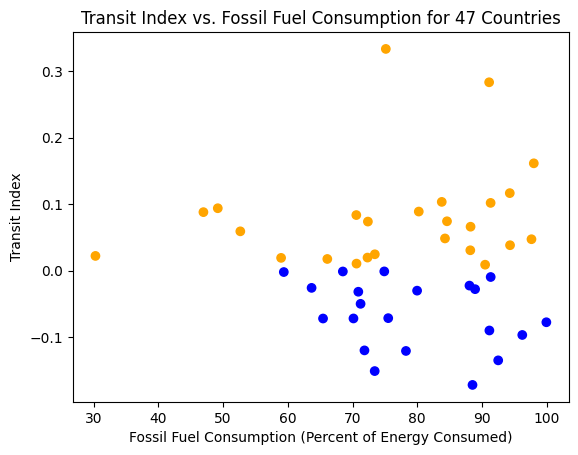

In [ ]:
# assign each country a transit index and compare to fossil fuel consumption

df_norm = fil_df.iloc[:,4:].values
df_norm = df_norm.astype(float)
norm_val = np.zeros((8,47)) # transit index array with half of countries as train data
for row in range(8):
    min_val = min(df_norm[row,:])
    max_val = max(df_norm[row,:])
    if row < 4:
        norm_val[row] = (df_norm[row] - min_val) / (max_val - min_val) # positive indicator
    else:
        norm_val[row] = (max_val - df_norm[row]) / (max_val - min_val) # negative indicator

tran_idx = np.zeros((1,47)) # transit index matrix
t_label = np.zeros((1,47)) # labels
for col in range(47):
    # weighted sum for transit index
    tran_idx[:,col] = 0.25*norm_val[0,col] + 0.1*norm_val[1,col] + 0.2*norm_val[2,col] + 0.1*norm_val[3,col] - 0.05*norm_val[4,col] - 0.05*norm_val[5,col] - 0.1*norm_val[6,col] - 0.1*norm_val[7,col]
    if tran_idx[:,col] >= 0: # transit-oriented
        t_label[:,col] = 1
    else: #transit-oriented
        t_label[:,col] = 0

x_den = fil_df.iloc[8,4:].values # ind. variable: fossil fuel consumption
x_den = x_den.astype(float)

X = np.zeros((2,47)) # combine ind. and dep. var into into one array
X[0,:] = x_den
X[1,:] = tran_idx

t_label = t_label.astype(int)

colors = ['blue' if t_label[:,i] == 0 else 'orange' for i in range(np.size(t_label))]
plt.figure()
plt.scatter (X[0,:], X[1,:], c= colors)
plt.title ('Transit Index vs. Fossil Fuel Consumption for 47 Countries')
plt.xlabel ('Fossil Fuel Consumption (Percent of Energy Consumed)')
plt.ylabel ('Transit Index')
plt.show ()

### Training Data

In [ ]:
# divide up data into training and test, 60/40 split

from sklearn.model_selection import train_test_split
X_transpose = X.T
t_label_flat = np.ravel(t_label)
X_train, X_test, y_train, y_test = train_test_split (X_transpose, t_label_flat, test_size=0.4, random_state=50)

In [11]:
# perceptron class

class Perceptron:

    def __init__(self, eta=0.01, epochs=1000):
        self.eta = eta
        self.epochs = epochs

    def _unit_step(self, X): # activation function
        return np.where(X >= 0, 1, 0)

    def train(self, X, y):
        self.weights = np.zeros(X.shape[1])
        self.bias = 0
        y_ = (y > 0).astype(int)

        for _ in range(self.epochs):
            for xi, target in zip(X, y_): # loop over training sample and target label
                output = self._unit_step(np.dot(xi, self.weights) + self.bias)
                update = self.eta * (target - output) # positive if underpredicting, negative if overpredicting
                self.weights += update * xi
                self.bias += update

    def predict(self, X):
        return self._unit_step(np.dot(X, self.weights) + self.bias) # apply act. func to summation of inputs/weights + bias

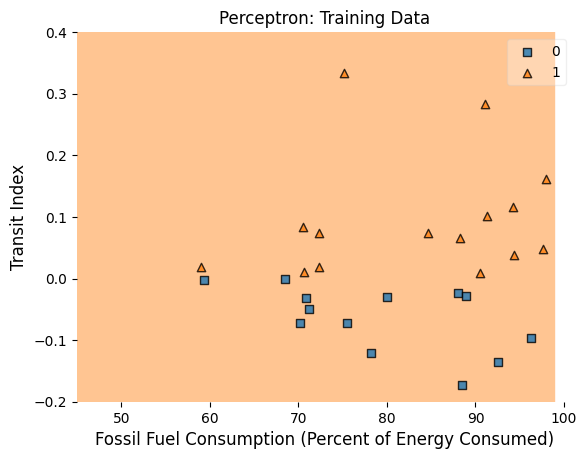

In [19]:
# run perceptron model on training data + establish boundaries
from mlxtend.plotting import plot_decision_regions # for plotting boundaries
percep = Perceptron(epochs=100)
percep.train(X_train, y_train)

plt.figure()
plot_decision_regions(X_train, y_train, clf=percep)
plt.gca().set(xlim=(45, 101), ylim=(-0.2, 0.4))
plt.title('Perceptron: Training Data')
plt.xlabel('Fossil Fuel Consumption (Percent of Energy Consumed)', fontsize = 12)
plt.ylabel('Transit Index', fontsize = 12)
plt.show()

### Test Data

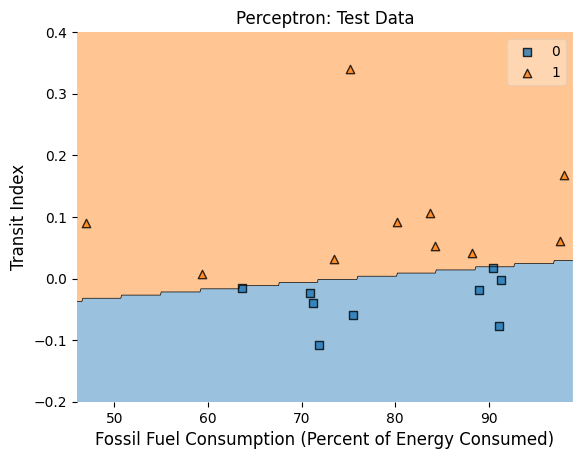

In [10]:
# apply trained model to test set and graph

y_pred= percep.predict(X_test)

plt.figure()
plot_decision_regions(X_test, y_pred, clf=percep)
plt.gca().set(xlim=(46, 99), ylim=(-0.2, 0.4) )
plt.title('Perceptron: Test Data')
plt.xlabel('Fossil Fuel Consumption (Percent of Energy Consumed)', fontsize = 12)
plt.ylabel('Transit Index', fontsize = 12)
plt.show()

Text(42.25, 0.5, 'True Label')

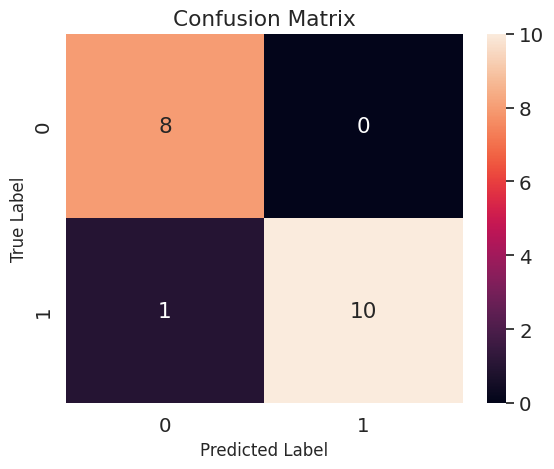

In [26]:
# create confusion matrix to assess accurate predications

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(pd.DataFrame(cm), annot=True, fmt='g', cbar=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)

### Conclusion

For the relationship between overall fossil fuels consumed and transit index, this model is relatively accuate since the model makes 1 error out of 19 predictions. However, it would have been helpful to have more data points overall as well as a data set that has a more distinct boundary. It would make sense that the less transit-oriented a country is, the more fossil fuels it uses but based on this data, these metrics are not correlated. The weights of the transit index should be assessed with empirical data, but on a rudimentary level, it is possible to determine if a country is transit-oriented based on its fossil fuel consumption and transit index. This may be helpful when determining the development of a country or even visiting a certain place. 